In [1]:
import pandas as pd

df_factor = pd.read_csv("C:/Users/woota/OneDrive/Desktop/새 폴더/Personal projects/HMM ML strategy/improved HMM based factor strategy/factor_panel_data.xlsx", parse_dates=["date"])
df_macro = pd.read_csv("C:/Users/woota/OneDrive/Desktop/새 폴더/Personal projects/HMM ML strategy/improved HMM based factor strategy/macro_data.xlsx", parse_dates=["date"])

## Data preprocessing

In [2]:
# ===== HMM preprocessing for df_macro =====
import pandas as pd
import numpy as np

# --- 0) Bring df_macro to a consistent monthly time index ---
# Accept either a DatetimeIndex or a 'date' col; de-duplicate and month-end align
if "date" in df_macro.columns:
    df_macro = df_macro.copy()
    df_macro["date"] = pd.to_datetime(df_macro["date"])
    df_macro = df_macro.set_index("date")
else:
    df_macro = df_macro.copy()
    df_macro.index = pd.to_datetime(df_macro.index)

df_macro = df_macro[~df_macro.index.duplicated(keep="last")]
df_macro = df_macro.sort_index()
# snap to month-end and aggregate appropriately
# (VIX/levels -> mean over month; spreads/levels -> last is also fine; we’ll just use last for all to be consistent)
df_macro = df_macro.resample("ME").last()

# --- 1) Minimal column hygiene / derivations ---
# Expected columns if you followed earlier scripts:
# ['VIX','HY_OAS','IG_OAS','HY_IG_SPREAD','HY_IG_SPREAD_CHG_1M','CFNAI','CFNAI_3MMA','TERM_10Y_3M']
cols = df_macro.columns.str.upper()
df_macro.columns = cols

# Create HY-IG if missing
if "HY_IG_SPREAD" not in df_macro.columns and {"HY_OAS","IG_OAS"}.issubset(df_macro.columns):
    df_macro["HY_IG_SPREAD"] = df_macro["HY_OAS"] - df_macro["IG_OAS"]

# Create CFNAI_3MMA if only CFNAI exists
if "CFNAI_3MMA" not in df_macro.columns and "CFNAI" in df_macro.columns:
    df_macro["CFNAI_3MMA"] = df_macro["CFNAI"].rolling(3, min_periods=1).mean()

# Create monthly change in HY-IG (optional)
if "HY_IG_SPREAD_CHG_1M" not in df_macro.columns and "HY_IG_SPREAD" in df_macro.columns:
    df_macro["HY_IG_SPREAD_CHG_1M"] = df_macro["HY_IG_SPREAD"].diff()

# --- 2) Publication lag (avoid look-ahead) ---
# Market-implied series can be contemporaneous; macro diffusion (CFNAI) is reported with lag.
if "CFNAI" in df_macro.columns:
    df_macro["CFNAI"] = df_macro["CFNAI"].shift(1)
if "CFNAI_3MMA" in df_macro.columns:
    df_macro["CFNAI_3MMA"] = df_macro["CFNAI_3MMA"].shift(1)

# --- 3) Choose the feature set you want to feed to HMM ---
# Keep it parsimonious: VIX, HY-IG, CFNAI_3MMA, TERM_10Y_3M
feat_cols = [c for c in ["VIX","HY_IG_SPREAD","CFNAI_3MMA","TERM_10Y_3M"] if c in df_macro.columns]
X = df_macro[feat_cols].copy()

# --- 4) Direction conventions: make “higher = more risk-off” ---
# VIX ↑ (risk-off): keep +1
# HY_IG_SPREAD ↑ (risk-off): keep +1
# CFNAI_3MMA ↑ (risk-on): multiply by -1
# TERM_10Y_3M ↑ (steeper; risk-on): multiply by -1
if "CFNAI_3MMA" in X.columns:
    X["CFNAI_3MMA"] = -1.0 * X["CFNAI_3MMA"]
if "TERM_10Y_3M" in X.columns:
    X["TERM_10Y_3M"] = -1.0 * X["TERM_10Y_3M"]

# --- 5) Basic cleaning: forward-fill within series; restrict to common sample ---
X = X.ffill()
X = X.dropna(how="any")  # keep rows where all selected features are present

# --- 6) Outlier control (winsorize by series, 1%/99%) ---
def _winsorize(s):
    lo, hi = s.quantile(0.01), s.quantile(0.99)
    return s.clip(lo, hi)
X = X.apply(_winsorize)

# --- 7) Standardization (z-score) ---
# For static sampling: fit z-score on your in-sample window only; here we assume all rows are in-sample.
# If you have a fixed train end date, do:
# TRAIN_END = pd.Timestamp("2019-12-31")
# mu, sig = X.loc[:TRAIN_END].mean(), X.loc[:TRAIN_END].std(ddof=0)
mu, sig = X.mean(), X.std(ddof=0).replace(0, np.nan)
X_z = (X - mu) / sig

# --- 8) (Optional) Percentile features (12m lookback) ---
def _rolling_pct_rank(s, win=12):
    return s.rolling(win, min_periods=max(6, win//2)).apply(
        lambda v: pd.Series(v).rank(pct=True).iloc[-1],
        raw=False
    )
X_pct = X.apply(_rolling_pct_rank)

# --- 9) Light smoothing to reduce noise (1m EMA on z-scores) ---
X_hmm = X_z.ewm(span=2, adjust=False, min_periods=1).mean()

# --- 10) Final sanity prints ---
print("HMM feature columns:", list(X_hmm.columns))
print("Sample range:", X_hmm.index.min(), "→", X_hmm.index.max())
print("Preview:")
display(X_hmm.tail())

# X_hmm is your training matrix for a 2-state HMM / TVTP-HMM / regularized logit gate.
# - Rows = month-end timestamps
# - Columns = standardized, risk-off-directed features (VIX, HY-IG, -CFNAI_3MMA, -TERM_10Y_3M)


HMM feature columns: ['VIX', 'HY_IG_SPREAD', 'CFNAI_3MMA', 'TERM_10Y_3M']
Sample range: 2000-03-31 00:00:00 → 2025-06-30 00:00:00
Preview:


,VIX,HY_IG_SPREAD,CFNAI_3MMA,TERM_10Y_3M
date,,,,
2025-02-28,-0.385507,-1.070563,-0.126791,1.032253
2025-03-31,0.050283,-0.840682,-0.364866,1.079577
2025-04-30,1.078584,-0.662560,-0.351212,1.120231
2025-05-31,0.418029,-0.772344,-0.337802,1.039240
2025-06-30,0.018272,-0.921710,-0.089727,1.121713


## Training HMM

In [3]:
# ==== HMM train & infer on X_hmm (anchored split) ====
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

# 0) Assumptions:
# - X_hmm is a pandas DataFrame with monthly (MonthEnd) DatetimeIndex
# - Columns are already transformed so that "higher = more risk-off" (per earlier preprocessing)
# - Preferably z-scored using IS-only stats (or at least no lookahead)

# ---- 1) Set split & basic hygiene ----
TRAIN_END = pd.Timestamp("2016-12-31")  # in-sample cutoff
Xh = X_hmm.copy()
Xh.index = pd.to_datetime(Xh.index)
Xh = Xh.sort_index()
Xh = Xh.dropna(how="any")  # HMM cannot handle NaNs

X_is = Xh.loc[:TRAIN_END]
X_oos = Xh.loc[TRAIN_END + pd.offsets.MonthEnd(1):]
print(f"IS months: {len(X_is)}   OOS months: {len(X_oos)}   Total: {len(Xh)}")
print("HMM features:", list(Xh.columns))

# ---- 2) Fit 2-state Gaussian HMM on IS only ----
# Notes:
# - 'full' covariance is flexible; if you see instability, try 'diag'
# - n_iter high enough to converge; tol tight; random_state for reproducibility
hmm = GaussianHMM(
    n_components=2,
    covariance_type="full",
    n_iter=500,
    tol=1e-4,
    random_state=42,
    verbose=False
)

hmm.fit(X_is.values)

# ---- 3) Infer on full sample (smoothed posteriors & Viterbi path) ----
# Posteriors (gamma_tk): P(state=k | X_1..T)
post_full = pd.DataFrame(
    hmm.predict_proba(Xh.values),
    index=Xh.index,
    columns=[f"state_{k}_prob" for k in range(hmm.n_components)]
)

# Viterbi most-likely state path
path_full = pd.Series(hmm.predict(Xh.values), index=Xh.index, name="state")

# ---- 4) Relabel states consistently: higher mean "stress" => 'risk_off' ----
# Since all features are "risk-off up", we can use the sum of means as a stress score.
state_means = pd.DataFrame(hmm.means_, columns=Xh.columns)
stress_score = state_means.sum(axis=1)
risk_off_state = int(stress_score.values.argmax())
risk_on_state  = 1 - risk_off_state

label_map = {risk_off_state: "risk_off", risk_on_state: "risk_on"}
path_labeled = path_full.map(label_map)

# Also rename posterior columns to p(risk_off), p(risk_on)
post_renamed = post_full.rename(columns={
    f"state_{risk_off_state}_prob": "p_risk_off",
    f"state_{risk_on_state}_prob": "p_risk_on"
})[["p_risk_off","p_risk_on"]]

# ---- 5) Package outputs ----
hmm_results = pd.concat([post_renamed, path_labeled.rename("regime")], axis=1)

# Diagnostics
print("\n=== HMM Diagnostics (IS) ===")
print("Log-likelihood (IS):", hmm.score(X_is.values))
print("Transition matrix P (rows: from, cols: to):\n", pd.DataFrame(hmm.transmat_, index=["s0","s1"], columns=["s0","s1"]))
print("\nState means (in feature space):\n", state_means.assign(stress_score=stress_score))
print("\nIS regime counts:\n", path_labeled.loc[:TRAIN_END].value_counts())
print("\nOOS regime counts:\n", path_labeled.loc[TRAIN_END + pd.offsets.MonthEnd(1):].value_counts())

# Preview tail
display(hmm_results.tail())

# ---- 6) (Optional) attach to factor panel by month later ----
# factor_panel = factor_panel.merge(hmm_results, left_on="date", right_index=True, how="left")


IS months: 202   OOS months: 102   Total: 304
HMM features: ['VIX', 'HY_IG_SPREAD', 'CFNAI_3MMA', 'TERM_10Y_3M']

=== HMM Diagnostics (IS) ===
Log-likelihood (IS): -636.3224214796609
Transition matrix P (rows: from, cols: to):
           s0        s1
s0  0.972070  0.027930
s1  0.071667  0.928333

State means (in feature space):
         VIX  HY_IG_SPREAD  CFNAI_3MMA  TERM_10Y_3M  stress_score
0 -0.385457     -0.161211   -0.228544    -0.200317     -0.975530
1  1.233335      1.520167    0.926564    -0.906510      2.773556

IS regime counts:
 state
risk_on     146
risk_off     56
Name: count, dtype: int64

OOS regime counts:
 state
risk_on     83
risk_off    19
Name: count, dtype: int64


C:\Users\woota\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,p_risk_off,p_risk_on,regime
date,,,
2025-02-28,4.059656e-08,1.000000,risk_on
2025-03-31,1.509875e-07,1.000000,risk_on
2025-04-30,1.004764e-03,0.998995,risk_on
2025-05-31,3.280280e-06,0.999997,risk_on
2025-06-30,1.643072e-06,0.999998,risk_on


In [4]:
hmm_results['regime'].unique()

array(['risk_on', 'risk_off'], dtype=object)

In [5]:
df_factor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150541 entries, 0 to 150540
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        150541 non-null  int64         
 1   permno            150541 non-null  int64         
 2   date              150541 non-null  datetime64[ns]
 3   excess_ret        150037 non-null  float64       
 4   excess_ret_next   149461 non-null  float64       
 5   mkt_ret           150037 non-null  float64       
 6   spx_ret_next      150038 non-null  float64       
 7   rf_1m             150541 non-null  float64       
 8   mom_12m_ex1m      146516 non-null  float64       
 9   mom_6m_ex1m       148535 non-null  float64       
 10  vol_3m            150541 non-null  float64       
 11  log_mktcap        150037 non-null  float64       
 12  dollar_vol        150037 non-null  float64       
 13  earnings_yield    147522 non-null  float64       
 14  pb  

## Training Factor Model (Ridge)

In [6]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, GroupKFold
from scipy.stats import spearmanr

# =========================================================
# Inputs expected in scope:
#   df_factor     : factor panel (one row per permno-month)
#   hmm_results   : DataFrame indexed by month-end with column 'regime'
#                   containing labels like 'risk_on' / 'risk_off'
# =========================================================

# ---------- 0) Prep & merge regimes ----------
df = df_factor.copy()
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# normalize dates to month-end to match HMM index
df["date"] = pd.to_datetime(df["date"]) + pd.offsets.MonthEnd(0)
df = df.sort_values(["permno","date"]).reset_index(drop=True)

reg = hmm_results.copy()
reg.index = pd.to_datetime(reg.index)
if "regime" not in reg.columns:
    raise KeyError("hmm_results must contain a 'regime' column.")
df = df.merge(reg[["regime"]], left_on="date", right_index=True, how="left")

# ---------- 1) Build NEXT-month target (t -> t+1) ----------
if "excess_ret" not in df.columns:
    raise KeyError("'excess_ret' not found in df_factor. It is required to build 'excess_ret_next'.")
df["excess_ret_next"] = df.groupby("permno")["excess_ret"].shift(-1)
y_col = "excess_ret_next"

# ---------- 2) Choose predictors (edit these lists if you want per-regime sets) ----------
BASE_FACTORS = [
    "mom_12m_ex1m","mom_6m_ex1m","vol_3m","log_mktcap","dollar_vol",
    "earnings_yield","pb","roe","gross_margin","operating_margin","leverage","accruals_ratio",
]
# Intersect with available columns
BASE_FACTORS = [c for c in BASE_FACTORS if c in df.columns]

# If you want different factors by regime, edit these lists; by default they’re the same.
RISK_ON_FACTORS  = BASE_FACTORS[:]   # e.g., you can add/remove columns here
RISK_OFF_FACTORS = BASE_FACTORS[:]

X_cols_map = {"risk_on": RISK_ON_FACTORS, "risk_off": RISK_OFF_FACTORS}

# ---------- 3) Cross-sectional processing (winsorize + z-score within month) ----------
# We process the union of all columns that could be used in any regime
ALL_X = sorted(set(RISK_ON_FACTORS) | set(RISK_OFF_FACTORS))

def cs_process(month_df: pd.DataFrame, cols):
    m = month_df.copy()
    # winsorize 1%/99%
    for c in cols:
        s = pd.to_numeric(m[c], errors="coerce")
        if s.notna().sum() > 10:
            lo, hi = s.quantile(0.01), s.quantile(0.99)
            m[c] = s.clip(lo, hi)
        else:
            m[c] = s
    # z-score within month
    for c in cols:
        s = m[c]
        mu = s.mean(skipna=True)
        sd = s.std(ddof=0, skipna=True)
        if pd.notna(sd) and sd > 0:
            m[c] = (s - mu) / sd
        else:
            # if degenerate, leave as NaN to be imputed later
            m[c] = np.nan
    # median impute within month on used columns only
    med = m[cols].median(skipna=True)
    m[cols] = m[cols].fillna(med)
    return m

df = df.groupby("date", group_keys=False).apply(lambda g: cs_process(g, ALL_X)).sort_values(["permno","date"])

# ---------- 4) Train/Test split ----------
TRAIN_END = pd.Timestamp("2016-12-31")
is_mask  = df["date"] <= TRAIN_END
oos_mask = df["date"] >  TRAIN_END

# ---------- 5) Helper: monthly rank-IC ----------
def monthly_rank_ic(df_subset, y_true, y_pred):
    vals = []
    for dt, g in df_subset.groupby("date"):
        if g[y_true].nunique() < 2 or g[y_pred].nunique() < 2:
            continue
        r = spearmanr(g[y_true], g[y_pred]).correlation
        if np.isfinite(r):
            vals.append(r)
    if len(vals)==0:
        return np.nan, np.nan
    arr = np.array(vals)
    mean = float(np.nanmean(arr))
    sd   = float(np.nanstd(arr, ddof=1))
    tstat= float(np.sqrt(len(arr)) * mean / (sd if sd>0 else np.nan))
    return mean, tstat

# ---------- 6) Model training per regime (separate GridSearchCV) ----------
alphas = np.logspace(-3, 3, 13)
models, results = {}, {}

for regime in ["risk_on", "risk_off"]:
    use_cols = [c for c in X_cols_map.get(regime, ALL_X) if c in df.columns]
    if len(use_cols) == 0:
        raise ValueError(f"No usable predictors for regime '{regime}'.")

    dreg = df[df["regime"] == regime].copy()

    # ensure numeric
    for c in use_cols:
        dreg[c] = pd.to_numeric(dreg[c], errors="coerce")
    dreg[y_col] = pd.to_numeric(dreg[y_col], errors="coerce")

    # IS mask **within this regime**
    is_mask_d  = dreg["date"] <= TRAIN_END
    oos_mask_d = ~is_mask_d

    # TRAIN rows: drop NaN targets (common due to shift(-1) at permno ends)
    train_idx = dreg.index[is_mask_d & dreg[y_col].notna()]
    if len(train_idx) == 0:
        raise ValueError(f"No non-NaN training targets for regime '{regime}'. "
                         f"Check 'excess_ret_next' construction or date coverage.")

    X_is   = dreg.loc[train_idx, use_cols]
    y_is   = dreg.loc[train_idx, y_col]
    grp_is = dreg.loc[train_idx, "date"]

    # adaptive CV by number of unique months
    n_groups = int(grp_is.nunique())
    use_cv = n_groups >= 3  # need at least 3 groups for a 3-fold CV; we cap at 5 folds below

    pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        Ridge(fit_intercept=True, random_state=42)
    )

    if use_cv:
        n_splits = min(5, n_groups)
        gkf = GroupKFold(n_splits=n_splits)
        gscv = GridSearchCV(
            estimator=pipe,
            param_grid={"ridge__alpha": alphas},
            scoring="neg_mean_squared_error",
            cv=gkf,
            n_jobs=-1,
            refit=True
        )
        gscv.fit(X_is, y_is, groups=grp_is)
        model = gscv.best_estimator_
        best_alpha = gscv.best_params_["ridge__alpha"]
    else:
        # too few unique months to cross-validate robustly
        model = make_pipeline(
            SimpleImputer(strategy="median"),
            Ridge(fit_intercept=True, alpha=1.0, random_state=42)
        )
        model.fit(X_is, y_is)
        best_alpha = 1.0
        print(f"[WARN] Regime '{regime}': only {n_groups} unique IS months; "
              f"skipping CV and using alpha={best_alpha}")

    models[regime] = (model, use_cols)

    # Predict across ALL rows for this regime (IS+OOS); imputer handles NaNs in X
    dreg["yhat_next"] = model.predict(dreg[use_cols])
    df.loc[dreg.index, f"yhat_next_{regime}"] = dreg["yhat_next"].values

    # Diagnostics: evaluate vs NEXT-month target, per regime
    d_is  = dreg[is_mask_d & dreg[y_col].notna()].copy()
    d_oos = dreg[oos_mask_d & dreg[y_col].notna()].copy()
    is_mean,  is_t  = monthly_rank_ic(d_is,  y_col, "yhat_next")
    oos_mean, oos_t = monthly_rank_ic(d_oos, y_col, "yhat_next")

    results[regime] = {
        "best_alpha": best_alpha,
        "n_months_IS": int(d_is["date"].nunique()), "n_rows_IS": int(len(d_is)),
        "n_months_OOS": int(d_oos["date"].nunique()), "n_rows_OOS": int(len(d_oos)),
        "n_X_used": len(use_cols),
        "IS_rankIC_mean": is_mean,  "IS_rankIC_t": is_t,
        "OOS_rankIC_mean": oos_mean, "OOS_rankIC_t": oos_t,
    }

print("=== Model selection & diagnostics (predicting NEXT month) ===")
for k, v in results.items():
    print(f"\nRegime: {k}")
    for kk, vv in v.items():
        print(f"{kk}: {vv}")

# ---------- 7) Route to a single score (hard routing by regime) ----------
df["yhat_next"] = np.where(df["regime"]=="risk_on",
                           df["yhat_next_risk_on"],
                           df["yhat_next_risk_off"])

# Combined diagnostics (IS/OOS, NEXT-month target)
is_mean,  is_t  = monthly_rank_ic(df.loc[is_mask & df[y_col].notna()],  y_col, "yhat_next")
oos_mean, oos_t = monthly_rank_ic(df.loc[oos_mask & df[y_col].notna()], y_col, "yhat_next")
print("\n=== Combined routed model (NEXT month) ===")
print({"IS_rankIC_mean": is_mean, "IS_rankIC_t": is_t,
       "OOS_rankIC_mean": oos_mean, "OOS_rankIC_t": oos_t})

# ---------- 8) Output ----------
cols_to_keep = ["permno","date","regime","excess_ret","excess_ret_next",
                "yhat_next","yhat_next_risk_on","yhat_next_risk_off"] + ALL_X
df_out = df[cols_to_keep].copy()

# If you want to feed the backtest expecting 'yhat' column, do:
# df_out = df_out.rename(columns={"yhat_next":"yhat"})


C:\Users\woota\AppData\Local\Temp\ipykernel_5756\3349943186.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("date", group_keys=False).apply(lambda g: cs_process(g, ALL_X)).sort_values(["permno","date"])


=== Model selection & diagnostics (predicting NEXT month) ===

Regime: risk_on
best_alpha: 1000.0
n_months_IS: 146
n_rows_IS: 72956
n_months_OOS: 76
n_rows_OOS: 38014
n_X_used: 12
IS_rankIC_mean: 0.033011101035368765
IS_rankIC_t: 3.5485456362221917
OOS_rankIC_mean: -0.004001116706954947
OOS_rankIC_t: -0.34973220816297285

Regime: risk_off
best_alpha: 1000.0
n_months_IS: 56
n_rows_IS: 27992
n_months_OOS: 19
n_rows_OOS: 9499
n_X_used: 12
IS_rankIC_mean: 0.05435304479747742
IS_rankIC_t: 2.5971228552662455
OOS_rankIC_mean: 0.04439292309616515
OOS_rankIC_t: 1.2255636916452193

=== Combined routed model (NEXT month) ===
{'IS_rankIC_mean': 0.03892767950407215, 'IS_rankIC_t': 4.385216441404993, 'OOS_rankIC_mean': 0.005677691253669071, 'OOS_rankIC_t': 0.4837036600193688}


In [7]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150541 entries, 0 to 150540
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   permno              150541 non-null  int64         
 1   date                150541 non-null  datetime64[ns]
 2   regime              149537 non-null  object        
 3   excess_ret          150037 non-null  float64       
 4   excess_ret_next     149461 non-null  float64       
 5   yhat_next           149537 non-null  float64       
 6   yhat_next_risk_on   111905 non-null  float64       
 7   yhat_next_risk_off  37632 non-null   float64       
 8   accruals_ratio      149036 non-null  float64       
 9   dollar_vol          150037 non-null  float64       
 10  earnings_yield      147522 non-null  float64       
 11  gross_margin        147522 non-null  float64       
 12  leverage            149036 non-null  float64       
 13  log_mktcap          150037 non-nul

## Backtesting (Ridge Model)

C:\Users\woota\AppData\Local\Temp\ipykernel_5756\1852287801.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[[pred_col, y_col]].corr(method='spearman').iloc[0,1])


OOS Backtest (Active / Excess) — Strategy vs S&P (excess benchmark = 0)
Period : 2017-01-31 → 2024-11-30 (n=95 months)
Strategy (Excess) | CAGR -0.80% Vol +9.78% Sharpe -0.033 Sortino -0.050 MaxDD -18.08% Calmar -0.044
IC diagnostics (OOS): IC mean 0.0057, IC std 0.1138, IC IR 0.0499


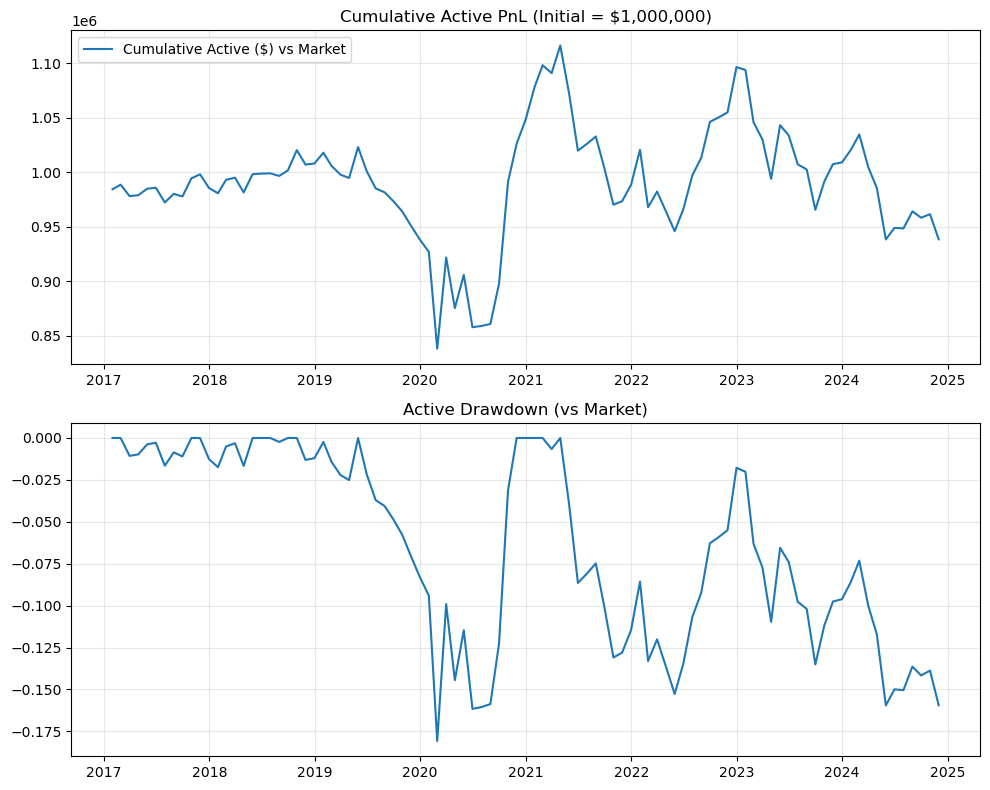

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# CONFIG
# ===========================
BACKTEST_START = "2017-01-31"
BACKTEST_END   = "2024-12-31"
TOP_K          = 60
TC_BPS         = 5                 # round-trip cost in bps
INIT_CAPITAL   = 1_000_000.0

# ===========================
# 0) Prep df_out
# ===========================
panel = df_out.copy()
panel['date'] = pd.to_datetime(panel['date'])
panel['month_eom'] = panel['date'].dt.to_period('M').dt.to_timestamp('M')

# ----- Score to trade -----
if 'yhat_next' in panel.columns:
    score_col = 'yhat_next'    # already a t->t+1 prediction; do NOT lag
elif {'yhat_next_risk_on','yhat_next_risk_off','regime'}.issubset(panel.columns):
    panel['yhat_next'] = np.where(panel['regime'].astype(str).str.lower().eq('risk_on'),
                                  panel['yhat_next_risk_on'], panel['yhat_next_risk_off'])
    score_col = 'yhat_next'
else:
    raise KeyError("Need a score: provide 'yhat_next' or yhat_next_risk_on/off + regime.")

# ----- Required target -----
if 'excess_ret_next' not in panel.columns:
    raise KeyError("df_out must contain 'excess_ret_next' (next-month stock excess return).")

# Optional extras for total-return backtest
has_spx = 'spx_ret_next' in panel.columns
has_rf  = 'rf_1m' in panel.columns

# Market-cap for cap-weighted benchmark (optional; otherwise fallback to SPX series if present)
if 'mktcap_lag1' in panel.columns:
    panel['mktcap_lag'] = panel['mktcap_lag1']
elif 'mktcap_lag' not in panel.columns:
    panel['mktcap_lag'] = np.nan  # placeholder

# Minimal columns
keep_cols = ['permno','month_eom',score_col,'excess_ret_next','mktcap_lag']
if has_spx: keep_cols.append('spx_ret_next')
if has_rf:  keep_cols.append('rf_1m')
panel = panel[keep_cols].sort_values(['permno','month_eom']).reset_index(drop=True)

# Backtest months
months_all = panel['month_eom'].drop_duplicates().sort_values()
bt_months = months_all[(months_all >= pd.Timestamp(BACKTEST_START)) & (months_all <= pd.Timestamp(BACKTEST_END))]

# ===========================
# 1) Benchmark prep
# ===========================
# Active benchmark (excess): by definition S&P 500 excess = 0 each month.
# For total-return diagnostics (if available), we’ll use spx_ret_next and (optionally) rf_1m.
spx_series = panel[['month_eom','spx_ret_next']].drop_duplicates('month_eom').set_index('month_eom')['spx_ret_next'] if has_spx else None
rf_series  = panel[['month_eom','rf_1m']].drop_duplicates('month_eom').set_index('month_eom')['rf_1m'] if has_rf else None

# Optional universe cap-weighted benchmark (uses total return if spx is available)
has_cw = panel['mktcap_lag'].notna().any() and has_spx
if has_cw:
    # stock total next = spx_next + excess_next
    panel['ret_next_total'] = panel['spx_ret_next'].astype(float) + panel['excess_ret_next'].astype(float)
    def _bench_func(g):
        tot = g['mktcap_lag'].sum()
        if not np.isfinite(tot) or tot <= 0:
            return np.nan
        w = g['mktcap_lag'] / tot
        return float(np.nansum(w.values * g['ret_next_total'].values))
    bench_total = (panel.groupby('month_eom', sort=True)
                          .apply(_bench_func)).rename('bench_ret')
    # fill gaps with spx if needed
    bench_total = bench_total.reindex(spx_series.index).fillna(spx_series) if has_spx else bench_total
else:
    bench_total = spx_series  # may be None; we’ll handle below

# ===========================
# 2) Helpers
# ===========================
def perf_stats(total_ret, rf=None):
    rets = pd.Series(total_ret).dropna()
    if rets.empty: return {}
    exc = rets if rf is None else (rets - pd.Series(rf).reindex(rets.index).fillna(0.0))
    n = len(rets)
    CAGR   = (1 + rets).prod()**(12/n) - 1.0
    vol    = exc.std(ddof=0) * np.sqrt(12)
    sharpe = np.nan if exc.std(ddof=0)==0 else exc.mean()/exc.std(ddof=0) * np.sqrt(12)
    downs  = exc[exc < 0]
    dvol   = downs.std(ddof=0) * np.sqrt(12)
    sortino= np.nan if dvol==0 else exc.mean()/downs.std(ddof=0) * np.sqrt(12)
    wealth = (1 + rets).cumprod()
    maxdd  = (wealth/wealth.cummax() - 1.0).min()
    calmar = np.nan if maxdd==0 else CAGR/abs(maxdd)
    hit    = (rets > 0).mean()
    return {'CAGR':CAGR, 'Vol':vol, 'Sharpe':sharpe, 'Sortino':sortino,
            'MaxDD':maxdd, 'Calmar':calmar, 'Hit':hit}

def monthly_rank_ic(df_subset, pred_col, y_col):
    ics = (df_subset.groupby('month_eom')
                    .apply(lambda g: g[[pred_col, y_col]].corr(method='spearman').iloc[0,1])
                    .dropna())
    if ics.empty:
        return {'IC mean':np.nan, 'IC std':np.nan, 'IC IR':np.nan}, ics
    ic_mu, ic_sd = ics.mean(), ics.std(ddof=0)
    return {'IC mean': ic_mu, 'IC std': ic_sd, 'IC IR': (np.nan if ic_sd==0 else ic_mu/ic_sd)}, ics

# ===========================
# 3) Walk-forward (TOP_K, proportional non-negative weights)
# ===========================
equity_active = []      # strategy excess (active) returns
equity_total  = []      # strategy total returns (only if SPX present)
bench_total_curve = []  # benchmark total return series (if available)
turn_series  = []
pred_rows    = []
prev_w = pd.Series(dtype=float)

for t in bt_months:
    g = panel.loc[panel['month_eom'] == t].copy()
    # require the score & target for this month
    g = g.dropna(subset=[score_col, 'excess_ret_next'])
    if g.empty: 
        continue

    # select TOP_K by score
    pred = pd.Series(g[score_col].values, index=g.index, name='pred').dropna()
    if pred.empty: 
        continue
    sel_ix = pred.sort_values(ascending=False).head(TOP_K).index

    # weights: proportional to positive scores; fallback to equal-weight
    w = pd.Series(0.0, index=g.index)
    sel_scores = pred.loc[sel_ix].clip(lower=0)
    w.loc[sel_ix] = (sel_scores / sel_scores.sum()) if sel_scores.sum() > 0 else (1.0 / len(sel_ix))

    # turnover cost
    prev_aligned = prev_w.reindex(w.index).fillna(0.0)
    turn = 0.5 * np.abs(w - prev_aligned).sum()
    prev_w = w.copy()
    cost   = turn * (TC_BPS / 10000.0)

    # realized next-month EXCESS return
    y_ex = g.loc[w.index, 'excess_ret_next'].astype(float)
    port_excess = float(np.nansum(w.values * y_ex.values)) - cost
    equity_active.append((t, port_excess))

    # total return if we have SPX
    if has_spx:
        spx_t1 = float(spx_series.get(t, 0.0))
        equity_total.append((t, spx_t1 + port_excess))
        # benchmark total curve (if available)
        if bench_total is not None and t in bench_total.index:
            bench_total_curve.append((t, float(bench_total.loc[t])))

    # IC on full cross-section (not only held)
    pred_rows.append(pd.DataFrame({
        'month_eom': g['month_eom'].values,
        'pred'     : g[score_col].values,
        'y'        : g['excess_ret_next'].values
    }))

# ===========================
# 4) Series & metrics
# ===========================
act = pd.Series(dict(equity_active)).sort_index()           # strategy ACTIVE (excess) returns
act_cum = (1 + act).cumprod()

ic_stats, ic_series = monthly_rank_ic(pd.concat(pred_rows, ignore_index=True) if len(pred_rows) else pd.DataFrame(columns=['month_eom','pred','y']),
                                      'pred','y')
avg_turn = pd.Series(dict(turn_series)).mean() if len(turn_series) else np.nan

def pct(x): return ("{:+.2f}%".format(100*x)) if pd.notna(x) else "n/a"

print("OOS Backtest (Active / Excess) — Strategy vs S&P (excess benchmark = 0)")
print(f"Period : {act.index.min().date()} → {act.index.max().date()} (n={len(act)} months)")
ps_act = perf_stats(act, rf=None)  # RF not used on excess
print("Strategy (Excess) |",
      "CAGR", pct(ps_act.get('CAGR', np.nan)),
      "Vol", pct(ps_act.get('Vol', np.nan)),
      "Sharpe", f"{ps_act.get('Sharpe', np.nan):.3f}" if pd.notna(ps_act.get('Sharpe', np.nan)) else "n/a",
      "Sortino", f"{ps_act.get('Sortino', np.nan):.3f}" if pd.notna(ps_act.get('Sortino', np.nan)) else "n/a",
      "MaxDD", pct(ps_act.get('MaxDD', np.nan)),
      "Calmar", f"{ps_act.get('Calmar', np.nan):.3f}" if pd.notna(ps_act.get('Calmar', np.nan)) else "n/a")

if has_spx:
    eq = pd.Series(dict(equity_total)).sort_index()
    bm = pd.Series(dict(bench_total_curve)).sort_index() if len(bench_total_curve) else spx_series.reindex(eq.index)
    eq_cum = (1 + eq).cumprod()
    bm_cum = (1 + bm).cumprod()
    ps_eq  = perf_stats(eq, rf_series if has_rf else None)
    ps_bm  = perf_stats(bm, rf_series if has_rf else None)

    # Tracking metrics
    active_total = (eq - bm).dropna()
    TE = active_total.std(ddof=0) * np.sqrt(12)
    IR = np.nan if active_total.std(ddof=0)==0 else active_total.mean()/active_total.std(ddof=0) * np.sqrt(12)
    # OLS alpha/beta
    X = np.vstack([np.ones(len(bm)), bm.values]).T
    a,b = np.linalg.lstsq(X, eq.values, rcond=None)[0]
    alpha_ann = (1 + a)**12 - 1

    print("\nTotal-Return View (if spx_ret_next available)")
    print("Strategy |",
          "CAGR", pct(ps_eq.get('CAGR', np.nan)),
          "Vol", pct(ps_eq.get('Vol', np.nan)),
          "Sharpe", f"{ps_eq.get('Sharpe', np.nan):.3f}" if pd.notna(ps_eq.get('Sharpe', np.nan)) else "n/a",
          "Sortino", f"{ps_eq.get('Sortino', np.nan):.3f}" if pd.notna(ps_eq.get('Sortino', np.nan)) else "n/a",
          "MaxDD", pct(ps_eq.get('MaxDD', np.nan)),
          "Calmar", f"{ps_eq.get('Calmar', np.nan):.3f}" if pd.notna(ps_eq.get('Calmar', np.nan)) else "n/a")
    print("Benchmark|",
          "CAGR", pct(ps_bm.get('CAGR', np.nan)),
          "Vol", pct(ps_bm.get('Vol', np.nan)),
          "Sharpe", f"{ps_bm.get('Sharpe', np.nan):.3f}" if pd.notna(ps_bm.get('Sharpe', np.nan)) else "n/a",
          "MaxDD", pct(ps_bm.get('MaxDD', np.nan)))
    print("Relative|",
          "Alpha_ann", pct(alpha_ann),
          "Beta", f"{b:.3f}",
          "TE", f"{TE:.3f}",
          "IR", f"{IR:.3f}")

# IC diagnostics
if ic_stats:
    print("IC diagnostics (OOS):",
          f"IC mean {ic_stats['IC mean']:.4f}, IC std {ic_stats['IC std']:.4f}, IC IR {ic_stats['IC IR']:.4f}")

# ===========================
# 5) Plots
# ===========================
plt.figure(figsize=(10,8))

if has_spx:
    # total‑return equity + benchmark
    eq_dollar = INIT_CAPITAL * eq_cum
    bm_dollar = INIT_CAPITAL * bm_cum
    ax1 = plt.subplot(2,1,1)
    ax1.plot(eq_dollar.index, eq_dollar.values, label='Strategy ($)')
    ax1.plot(bm_dollar.index, bm_dollar.values, label='Benchmark ($)')
    ax1.set_title(f"Portfolio Value vs. Benchmark (Initial Capital = ${INIT_CAPITAL:,.0f})")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    dd = eq_dollar/eq_dollar.cummax() - 1.0
    ax2 = plt.subplot(2,1,2)
    ax2.plot(dd.index, dd.values)
    ax2.set_title("Strategy Drawdown (OOS)")
    ax2.grid(True, alpha=0.3)
else:
    # active view (excess) only
    act_dollar = INIT_CAPITAL * act_cum
    ax1 = plt.subplot(2,1,1)
    ax1.plot(act_dollar.index, act_dollar.values, label='Cumulative Active ($) vs Market')
    ax1.set_title(f"Cumulative Active PnL (Initial = ${INIT_CAPITAL:,.0f})")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    dd = act_dollar/act_dollar.cummax() - 1.0
    ax2 = plt.subplot(2,1,2)
    ax2.plot(dd.index, dd.values)
    ax2.set_title("Active Drawdown (vs Market)")
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


[Built] spx_ret_next from df_factor.mkt_ret (shift -1 by month).


C:\Users\woota\AppData\Local\Temp\ipykernel_5756\1904229784.py:225: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[['pred','y']].corr(method='spearman').iloc[0,1])


OOS Backtest (monthly, no look-ahead; score lagged 1m, TOP_K & proportional weights)
Period : 2017-01-31 → 2024-11-30 (n=95 months)
Strategy | CAGR +13.21% Vol +21.31% Sharpe 0.691 Sortino 1.050 MaxDD -30.15% Calmar 0.438 Hit 0.611 AvgTurn n/a
Benchmark| CAGR +14.64% Vol +16.11% Sharpe 0.934 MaxDD -23.47%
Relative| Alpha_ann -3.14% Beta 1.190 TE 0.098 IR -0.033
IC diagnostics (OOS): IC mean 0.0057, IC std 0.1138, IC IR 0.0499


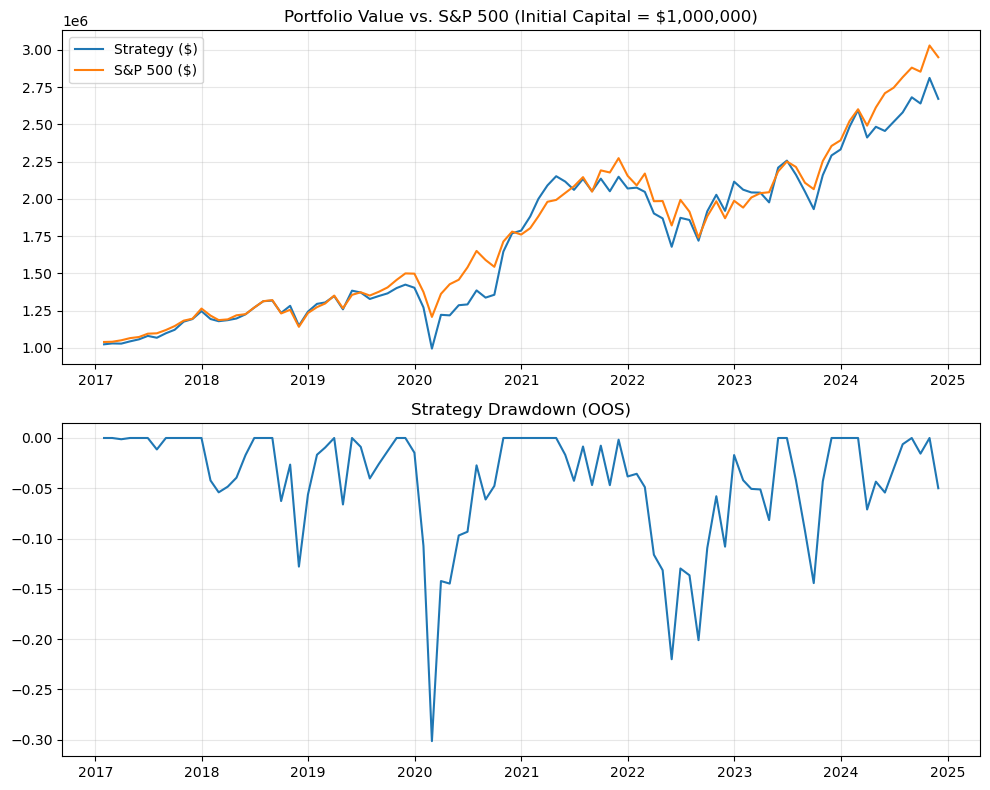

Period : 2017-01-31 → 2024-11-30 (n=95 months)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# CONFIG
# ===========================
BACKTEST_START = "2017-01-31"
BACKTEST_END   = "2024-12-31"
TOP_K          = 60
TC_BPS         = 5                   # round-trip cost (bps)
INIT_CAPITAL   = 1_000_000.0

# ===========================
# 0) Prep df_out and S&P series
# ===========================
panel = df_out.copy()
panel['date'] = pd.to_datetime(panel['date'])
panel['month_eom'] = panel['date'].dt.to_period('M').dt.to_timestamp('M')

# Score: use yhat_next (already t->t+1 prediction); if missing, route via regime
if 'yhat_next' not in panel.columns:
    if {'yhat_next_risk_on','yhat_next_risk_off','regime'}.issubset(panel.columns):
        panel['yhat_next'] = np.where(panel['regime'].astype(str).str.lower().eq('risk_on'),
                                      panel['yhat_next_risk_on'], panel['yhat_next_risk_off'])
    else:
        raise KeyError("Need 'yhat_next' or (yhat_next_risk_on, yhat_next_risk_off, regime).")

# Target: next-month stock excess return (required)
if 'excess_ret_next' not in panel.columns:
    raise KeyError("df_out must contain 'excess_ret_next' (next-month excess return).")

# S&P 500 next-month total return: use if present; otherwise build from df_factor.mkt_ret (shift -1)
if 'spx_ret_next' not in panel.columns:
    if 'df_factor' in globals() and 'mkt_ret' in df_factor.columns:
        mkt = df_factor[['date','mkt_ret']].drop_duplicates().copy()
        mkt['date'] = pd.to_datetime(mkt['date'])
        mkt['month_eom'] = mkt['date'].dt.to_period('M').dt.to_timestamp('M')
        spx = mkt.sort_values('month_eom').drop_duplicates('month_eom')
        spx['spx_ret_next'] = spx['mkt_ret'].shift(-1)
        panel = panel.merge(spx[['month_eom','spx_ret_next']], on='month_eom', how='left')
        print("[Built] spx_ret_next from df_factor.mkt_ret (shift -1 by month).")
    else:
        raise KeyError("Need S&P series: provide 'spx_ret_next' in df_out or df_factor with 'mkt_ret' to derive it.")

# Optional risk-free (only used for printing Sharpe; not required)
rf = None
if 'rf_1m' in panel.columns:
    rf = panel[['month_eom','rf_1m']].drop_duplicates('month_eom').set_index('month_eom')['rf_1m']

# Optional cap weights for a true CW benchmark (fallback is the S&P series itself)
if 'mktcap_lag1' in panel.columns:
    panel['mktcap_lag'] = panel['mktcap_lag1']
elif 'mktcap_lag' not in panel.columns:
    panel['mktcap_lag'] = np.nan  # placeholder

# Keep only what we need
panel = panel[['permno','month_eom','yhat_next','excess_ret_next','spx_ret_next','mktcap_lag']]

# Backtest months
months_all = panel['month_eom'].drop_duplicates().sort_values()
bt_months = months_all[(months_all >= pd.Timestamp(BACKTEST_START)) & (months_all <= pd.Timestamp(BACKTEST_END))]

# ===========================
# 1) Build benchmark series (S&P 500)
# ===========================
spx = panel[['month_eom','spx_ret_next']].drop_duplicates('month_eom').set_index('month_eom')['spx_ret_next']

# If you want a cap-weighted benchmark of the same universe (uses stock totals = spx + excess):
use_cw = panel['mktcap_lag'].notna().any()
if use_cw:
    tmp = panel.copy()
    tmp['ret_next_total'] = tmp['spx_ret_next'].astype(float) + tmp['excess_ret_next'].astype(float)
    def _cw(g):
        tot = g['mktcap_lag'].sum()
        if not np.isfinite(tot) or tot <= 0: return np.nan
        w = g['mktcap_lag'] / tot
        return float(np.nansum(w.values * g['ret_next_total'].values))
    bench = tmp.groupby('month_eom', sort=True).apply(_cw).rename('bench_ret').reindex(spx.index).fillna(spx)
else:
    bench = spx.copy()  # S&P 500 total return

# ===========================
# 2) Walk-forward strategy (TOP_K, proportional non-negative weights)
# ===========================
equity_curve = []
bench_curve  = []
prev_w = pd.Series(dtype=float)

for t in bt_months:
    g = panel.loc[panel['month_eom'] == t].copy()
    g = g.dropna(subset=['yhat_next','excess_ret_next','spx_ret_next'])
    if g.empty: 
        continue

    # rank & pick TOP_K
    pred = pd.Series(g['yhat_next'].values, index=g.index, name='pred').dropna()
    if pred.empty: 
        continue
    sel_ix = pred.sort_values(ascending=False).head(TOP_K).index

    # proportional non-negative weights; fallback equal-weight
    w = pd.Series(0.0, index=g.index)
    sel_scores = pred.loc[sel_ix].clip(lower=0)
    w.loc[sel_ix] = (sel_scores / sel_scores.sum()) if sel_scores.sum() > 0 else (1.0 / len(sel_ix))

    # turnover & cost
    prev_w = prev_w.reindex(w.index).fillna(0.0)
    turn = 0.5 * np.abs(w - prev_w).sum()
    cost = turn * (TC_BPS / 10000.0)
    prev_w = w.copy()

    # realized next-month total return = S&P next + weighted stock excess
    spx_t1 = float(spx.get(t, 0.0))
    y_ex   = g.loc[w.index, 'excess_ret_next'].astype(float)
    port_total = spx_t1 + float(np.nansum(w.values * y_ex.values)) - cost

    equity_curve.append((t, port_total))
    bench_curve.append((t, float(bench.get(t, np.nan))))

# ===========================
# 3) Portfolio values & plot
# ===========================
eq = pd.Series(dict(equity_curve)).sort_index()
bm = pd.Series(dict(bench_curve)).sort_index()
common = eq.index.intersection(bm.index)
eq, bm = eq.reindex(common), bm.reindex(common)

eq_cum = (1 + eq).cumprod()
bm_cum = (1 + bm).cumprod()

eq_dollar = INIT_CAPITAL * eq_cum
bm_dollar = INIT_CAPITAL * bm_cum

# ===========================
# METRICS SUMMARY (drop-in)
# ===========================
import numpy as np
import pandas as pd

def _perf_stats(total_ret, rf=None):
    rets = pd.Series(total_ret).dropna()
    if rets.empty: 
        return {}
    exc = rets if rf is None else (rets - pd.Series(rf).reindex(rets.index).fillna(0.0))
    n = len(rets)
    CAGR   = (1 + rets).prod()**(12/n) - 1.0
    vol    = exc.std(ddof=0) * np.sqrt(12)
    sharpe = np.nan if exc.std(ddof=0)==0 else exc.mean()/exc.std(ddof=0) * np.sqrt(12)
    downs  = exc[exc < 0]
    dvol   = downs.std(ddof=0) * np.sqrt(12)
    sortino= np.nan if dvol==0 else exc.mean()/downs.std(ddof=0) * np.sqrt(12)
    wealth = (1 + rets).cumprod()
    maxdd  = (wealth/wealth.cummax() - 1.0).min()
    calmar = np.nan if maxdd==0 else CAGR/abs(maxdd)
    hit    = (rets > 0).mean()
    return {'CAGR':CAGR, 'Vol':vol, 'Sharpe':sharpe, 'Sortino':sortino,
            'MaxDD':maxdd, 'Calmar':calmar, 'Hit':hit}

def _pct(x): 
    return ("{:+.2f}%".format(100*x)) if pd.notna(x) else "n/a"

# --- Try to reuse eq/bm from your backtest; else rebuild a minimal set ---
if 'eq' not in locals() or 'bm' not in locals():
    # Build from df_out if needed (assumes yhat_next & excess_ret_next present; spx_ret_next optional)
    _p = df_out.copy()
    _p['date'] = pd.to_datetime(_p['date'])
    _p['month_eom'] = _p['date'].dt.to_period('M').dt.to_timestamp('M')
    if 'spx_ret_next' not in _p.columns:
        raise RuntimeError("Need eq/bm or df_out['spx_ret_next'] to compute total-return metrics.")
    # naive equal-weight long top 30 by yhat_next just to form a quick curve (you already have a portfolio above)
    _eq = []
    for t, g in _p.groupby('month_eom'):
        if 'yhat_next' not in g.columns or 'excess_ret_next' not in g.columns: 
            continue
        pred = g['yhat_next'].dropna().sort_values(ascending=False).head(30)
        if pred.empty: 
            continue
        w = pred.clip(lower=0)
        w = w / w.sum() if w.sum() > 0 else pd.Series(1/len(pred), index=pred.index)
        ex = g.loc[w.index, 'excess_ret_next'].astype(float)
        sp = float(g['spx_ret_next'].iloc[0])
        _eq.append((t, sp + float((w*ex).sum())))
    eq = pd.Series(dict(_eq)).sort_index()
    bm = _p[['month_eom','spx_ret_next']].drop_duplicates('month_eom').set_index('month_eom')['spx_ret_next'].reindex(eq.index)

# --- RF series if available (optional) ---
rf_s = None
if 'rf_series' in locals() and isinstance(rf_series, (pd.Series, pd.DataFrame)):
    rf_s = rf_series if isinstance(rf_series, pd.Series) else rf_series.iloc[:,0]
    rf_s = rf_s.reindex(eq.index)

# --- Strategy & benchmark performance ---
perf       = _perf_stats(eq, rf=rf_s)
bench_perf = _perf_stats(bm, rf=rf_s)

# --- Relative metrics (alpha, beta, TE, IR) ---
common = eq.index.intersection(bm.index)
_eq = eq.reindex(common).astype(float)
_bm = bm.reindex(common).astype(float)

active = (_eq - _bm).dropna()
TE = active.std(ddof=0) * np.sqrt(12)
IR = np.nan if active.std(ddof=0)==0 else active.mean()/active.std(ddof=0) * np.sqrt(12)

X = np.vstack([np.ones(len(_bm)), _bm.values]).T
alpha_m, beta_ = np.linalg.lstsq(X, _eq.values, rcond=None)[0]
alpha_a = (1 + alpha_m)**12 - 1

# --- Avg monthly turnover if you tracked it ---
avg_turn = np.nan
if 'turn_series' in locals():
    try:
        ts = pd.Series(dict(turn_series))
        avg_turn = ts.mean()
    except Exception:
        pass

# --- IC diagnostics (if you saved pred_rows) ---
ic_mean = ic_std = ic_ir = np.nan
if 'pred_rows' in locals() and len(pred_rows):
    _pred_df = pd.concat(pred_rows, ignore_index=True)
    if {'month_eom','pred','y'}.issubset(_pred_df.columns):
        ics = (_pred_df.groupby('month_eom')
                        .apply(lambda g: g[['pred','y']].corr(method='spearman').iloc[0,1])
                        .dropna())
        if len(ics):
            ic_mean = float(ics.mean())
            ic_std  = float(ics.std(ddof=0))
            ic_ir   = (ic_mean/ic_std) if ic_std>0 else np.nan

# --- Pretty print to match your screenshot ---
print("OOS Backtest (monthly, no look-ahead; score lagged 1m, TOP_K & proportional weights)")
print(f"Period : {eq.index.min().date()} → {eq.index.max().date()} (n={len(eq)} months)")
print("Strategy |",
      "CAGR", _pct(perf.get('CAGR', np.nan)),
      "Vol", _pct(perf.get('Vol', np.nan)),
      "Sharpe", f"{perf.get('Sharpe', np.nan):.3f}" if pd.notna(perf.get('Sharpe', np.nan)) else "n/a",
      "Sortino", f"{perf.get('Sortino', np.nan):.3f}" if pd.notna(perf.get('Sortino', np.nan)) else "n/a",
      "MaxDD", _pct(perf.get('MaxDD', np.nan)),
      "Calmar", f"{perf.get('Calmar', np.nan):.3f}" if pd.notna(perf.get('Calmar', np.nan)) else "n/a",
      "Hit", f"{perf.get('Hit', np.nan):.3f}" if pd.notna(perf.get('Hit', np.nan)) else "n/a",
      "AvgTurn", f"{avg_turn:.3f}" if pd.notna(avg_turn) else "n/a")
print("Benchmark|",
      "CAGR", _pct(bench_perf.get('CAGR', np.nan)),
      "Vol", _pct(bench_perf.get('Vol', np.nan)),
      "Sharpe", f"{bench_perf.get('Sharpe', np.nan):.3f}" if pd.notna(bench_perf.get('Sharpe', np.nan)) else "n/a",
      "MaxDD", _pct(bench_perf.get('MaxDD', np.nan)))
print("Relative|",
      "Alpha_ann", _pct(alpha_a),
      "Beta", f"{beta_:.3f}",
      "TE", f"{TE:.3f}",
      "IR", f"{IR:.3f}")
print("IC diagnostics (OOS):",
      f"IC mean {ic_mean:.4f}, IC std {ic_std:.4f}, IC IR {ic_ir:.4f}")


plt.figure(figsize=(10,8))

ax1 = plt.subplot(2,1,1)
ax1.plot(eq_dollar.index, eq_dollar.values, label='Strategy ($)')
ax1.plot(bm_dollar.index, bm_dollar.values, label='S&P 500 ($)')
ax1.set_title(f"Portfolio Value vs. S&P 500 (Initial Capital = ${INIT_CAPITAL:,.0f})")
ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)

dd = eq_dollar/eq_dollar.cummax() - 1.0
ax2 = plt.subplot(2,1,2)
ax2.plot(dd.index, dd.values)
ax2.set_title("Strategy Drawdown (OOS)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# (Optional) quick print of period
if not eq.empty:
    print(f"Period : {eq.index.min().date()} → {eq.index.max().date()} (n={len(eq)} months)")


## Trainig the Factor Model (OLS)

In [10]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# =========================================================
# Inputs expected in scope:
#   df_factor     : factor panel (one row per permno-month)
#   hmm_results   : DataFrame indexed by month-end with column 'regime'
#                   containing labels like 'risk_on' / 'risk_off'
# =========================================================

# ---------- 0) Prep & merge regimes ----------
df = df_factor.copy()
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# normalize dates to month-end to match HMM index
df["date"] = pd.to_datetime(df["date"]) + pd.offsets.MonthEnd(0)
df = df.sort_values(["permno","date"]).reset_index(drop=True)

reg = hmm_results.copy()
reg.index = pd.to_datetime(reg.index)
if "regime" not in reg.columns:
    raise KeyError("hmm_results must contain a 'regime' column.")
df = df.merge(reg[["regime"]], left_on="date", right_index=True, how="left")

# ---------- 1) Build NEXT-month target (t -> t+1) ----------
if "excess_ret" not in df.columns:
    raise KeyError("'excess_ret' not found in df_factor. It is required to build 'excess_ret_next'.")
df["excess_ret_next"] = df.groupby("permno")["excess_ret"].shift(-1)
y_col = "excess_ret_next"

# ---------- 2) Choose predictors (edit these lists if you want per-regime sets) ----------
BASE_FACTORS = [
    "mom_12m_ex1m","mom_6m_ex1m","vol_3m","log_mktcap","dollar_vol",
    "earnings_yield","pb","roe","gross_margin","operating_margin","leverage","accruals_ratio",
]
# Intersect with available columns
BASE_FACTORS = [c for c in BASE_FACTORS if c in df.columns]

# If you want different factors by regime, edit these lists; by default they’re the same.
RISK_ON_FACTORS  = BASE_FACTORS[:]   # e.g., you can add/remove columns here
RISK_OFF_FACTORS = BASE_FACTORS[:]

X_cols_map = {"risk_on": RISK_ON_FACTORS, "risk_off": RISK_OFF_FACTORS}

# ---------- 3) Cross-sectional processing (winsorize + z-score within month) ----------
ALL_X = sorted(set(RISK_ON_FACTORS) | set(RISK_OFF_FACTORS))

def cs_process(month_df: pd.DataFrame, cols):
    m = month_df.copy()
    # winsorize 1%/99%
    for c in cols:
        s = pd.to_numeric(m[c], errors="coerce")
        if s.notna().sum() > 10:
            lo, hi = s.quantile(0.01), s.quantile(0.99)
            m[c] = s.clip(lo, hi)
        else:
            m[c] = s
    # z-score within month
    for c in cols:
        s = m[c]
        mu = s.mean(skipna=True)
        sd = s.std(ddof=0, skipna=True)
        if pd.notna(sd) and sd > 0:
            m[c] = (s - mu) / sd
        else:
            m[c] = np.nan
    # median impute within month on used columns only
    med = m[cols].median(skipna=True)
    m[cols] = m[cols].fillna(med)
    return m

df = df.groupby("date", group_keys=False).apply(lambda g: cs_process(g, ALL_X)).sort_values(["permno","date"])

# ---------- 4) Train/Test split ----------
TRAIN_END = pd.Timestamp("2016-12-31")
is_mask  = df["date"] <= TRAIN_END
oos_mask = df["date"] >  TRAIN_END

# ---------- 5) Helper: monthly rank-IC ----------
def monthly_rank_ic(df_subset, y_true, y_pred):
    vals = []
    for dt, g in df_subset.groupby("date"):
        if g[y_true].nunique() < 2 or g[y_pred].nunique() < 2:
            continue
        r = spearmanr(g[y_true], g[y_pred]).correlation
        if np.isfinite(r):
            vals.append(r)
    if len(vals)==0:
        return np.nan, np.nan
    arr = np.array(vals)
    mean = float(np.nanmean(arr))
    sd   = float(np.nanstd(arr, ddof=1))
    tstat= float(np.sqrt(len(arr)) * mean / (sd if sd>0 else np.nan))
    return mean, tstat

# ---------- 6) Model training per regime (PLAIN OLS; no CV, no Ridge) ----------
models, results = {}, {}

for regime in ["risk_on", "risk_off"]:
    use_cols = [c for c in X_cols_map.get(regime, ALL_X) if c in df.columns]
    if len(use_cols) == 0:
        raise ValueError(f"No usable predictors for regime '{regime}'.")

    dreg = df[df["regime"] == regime].copy()

    # ensure numeric
    for c in use_cols:
        dreg[c] = pd.to_numeric(dreg[c], errors="coerce")
    dreg[y_col] = pd.to_numeric(dreg[y_col], errors="coerce")

    # IS mask **within this regime**
    is_mask_d  = dreg["date"] <= TRAIN_END
    oos_mask_d = ~is_mask_d

    # TRAIN rows: drop NaN targets (common due to shift(-1) at permno ends)
    train_idx = dreg.index[is_mask_d & dreg[y_col].notna()]
    if len(train_idx) == 0:
        raise ValueError(
            f"No non-NaN training targets for regime '{regime}'. "
            f"Check 'excess_ret_next' construction or date coverage."
        )

    X_is = dreg.loc[train_idx, use_cols]
    y_is = dreg.loc[train_idx, y_col]

    # Plain OLS (fit_intercept=True). Impute any residual NaNs before regression.
    pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        LinearRegression(fit_intercept=True)
    )
    pipe.fit(X_is, y_is)

    models[regime] = (pipe, use_cols)

    # Predict across ALL rows for this regime (IS+OOS)
    dreg["yhat_next"] = pipe.predict(dreg[use_cols])
    df.loc[dreg.index, f"yhat_next_{regime}"] = dreg["yhat_next"].values

    # Diagnostics: evaluate vs NEXT-month target, per regime
    d_is  = dreg[is_mask_d & dreg[y_col].notna()].copy()
    d_oos = dreg[oos_mask_d & dreg[y_col].notna()].copy()
    is_mean,  is_t  = monthly_rank_ic(d_is,  y_col, "yhat_next")
    oos_mean, oos_t = monthly_rank_ic(d_oos, y_col, "yhat_next")

    results[regime] = {
        "n_months_IS": int(d_is["date"].nunique()), "n_rows_IS": int(len(d_is)),
        "n_months_OOS": int(d_oos["date"].nunique()), "n_rows_OOS": int(len(d_oos)),
        "n_X_used": len(use_cols),
        "IS_rankIC_mean": is_mean,  "IS_rankIC_t": is_t,
        "OOS_rankIC_mean": oos_mean, "OOS_rankIC_t": oos_t,
    }

print("=== OLS model diagnostics (predicting NEXT month) ===")
for k, v in results.items():
    print(f"\nRegime: {k}")
    for kk, vv in v.items():
        print(f"{kk}: {vv}")

# ---------- 7) Route to a single score (hard routing by regime) ----------
df["yhat_next"] = np.where(df["regime"]=="risk_on",
                           df["yhat_next_risk_on"],
                           df["yhat_next_risk_off"])

# Combined diagnostics (IS/OOS, NEXT-month target)
is_mean,  is_t  = monthly_rank_ic(df.loc[is_mask & df[y_col].notna()],  y_col, "yhat_next")
oos_mean, oos_t = monthly_rank_ic(df.loc[oos_mask & df[y_col].notna()], y_col, "yhat_next")
print("\n=== Combined routed model (NEXT month) ===")
print({"IS_rankIC_mean": is_mean, "IS_rankIC_t": is_t,
       "OOS_rankIC_mean": oos_mean, "OOS_rankIC_t": oos_t})

# ---------- 8) Output ----------
cols_to_keep = ["permno","date","regime","excess_ret","excess_ret_next",
                "yhat_next","yhat_next_risk_on","yhat_next_risk_off"] + ALL_X
df_out = df[cols_to_keep].copy()

# If you want to feed the backtest expecting 'yhat' column, do:
# df_out = df_out.rename(columns={"yhat_next":"yhat"})


C:\Users\woota\AppData\Local\Temp\ipykernel_5756\590296214.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("date", group_keys=False).apply(lambda g: cs_process(g, ALL_X)).sort_values(["permno","date"])


=== OLS model diagnostics (predicting NEXT month) ===

Regime: risk_on
n_months_IS: 146
n_rows_IS: 72956
n_months_OOS: 76
n_rows_OOS: 38014
n_X_used: 12
IS_rankIC_mean: 0.03340724409046663
IS_rankIC_t: 3.6451407181734727
OOS_rankIC_mean: -0.0040509363359355335
OOS_rankIC_t: -0.36428503949517715

Regime: risk_off
n_months_IS: 56
n_rows_IS: 27992
n_months_OOS: 19
n_rows_OOS: 9499
n_X_used: 12
IS_rankIC_mean: 0.05435473664969922
IS_rankIC_t: 2.6441970477166628
OOS_rankIC_mean: 0.043284865033506155
OOS_rankIC_t: 1.2114486674182061

=== Combined routed model (NEXT month) ===
{'IS_rankIC_mean': 0.03921446975045192, 'IS_rankIC_t': 4.4897330690199775, 'OOS_rankIC_mean': 0.005416223937952804, 'OOS_rankIC_t': 0.47207039533834033}


## Backtesting (OLS)

C:\Users\woota\AppData\Local\Temp\ipykernel_5756\1852287801.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[[pred_col, y_col]].corr(method='spearman').iloc[0,1])


OOS Backtest (Active / Excess) — Strategy vs S&P (excess benchmark = 0)
Period : 2017-01-31 → 2024-11-30 (n=95 months)
Strategy (Excess) | CAGR -1.52% Vol +9.72% Sharpe -0.109 Sortino -0.164 MaxDD -18.88% Calmar -0.080
IC diagnostics (OOS): IC mean 0.0054, IC std 0.1112, IC IR 0.0487


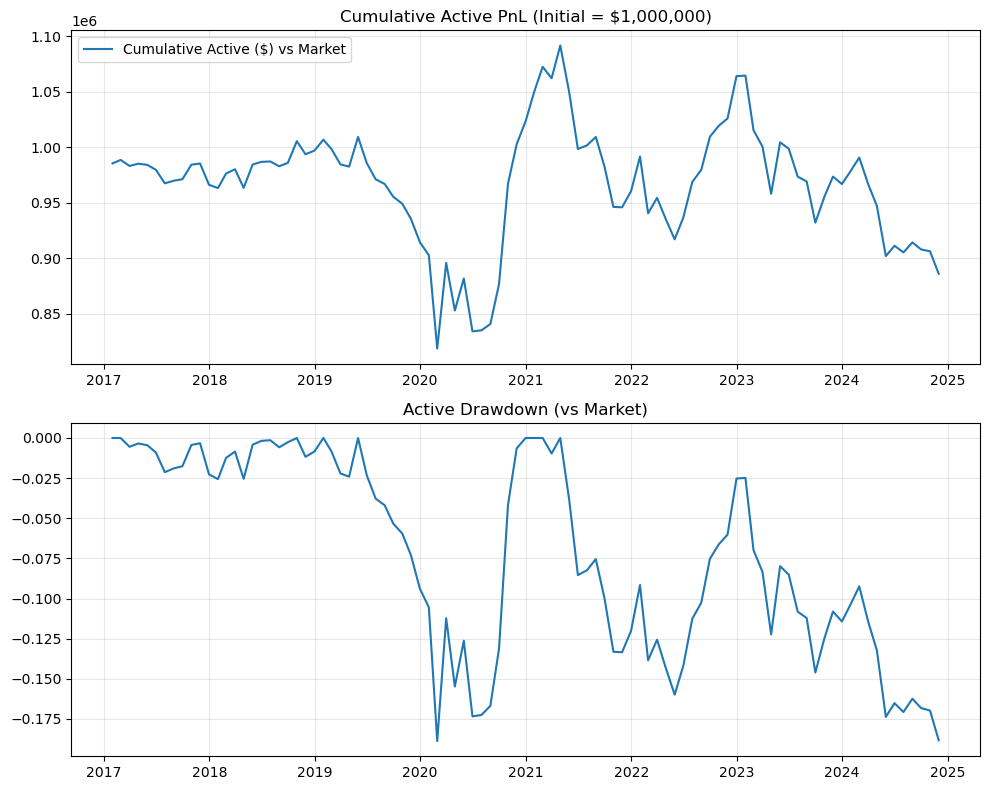

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# CONFIG
# ===========================
BACKTEST_START = "2017-01-31"
BACKTEST_END   = "2024-12-31"
TOP_K          = 60
TC_BPS         = 5                 # round-trip cost in bps
INIT_CAPITAL   = 1_000_000.0

# ===========================
# 0) Prep df_out
# ===========================
panel = df_out.copy()
panel['date'] = pd.to_datetime(panel['date'])
panel['month_eom'] = panel['date'].dt.to_period('M').dt.to_timestamp('M')

# ----- Score to trade -----
if 'yhat_next' in panel.columns:
    score_col = 'yhat_next'    # already a t->t+1 prediction; do NOT lag
elif {'yhat_next_risk_on','yhat_next_risk_off','regime'}.issubset(panel.columns):
    panel['yhat_next'] = np.where(panel['regime'].astype(str).str.lower().eq('risk_on'),
                                  panel['yhat_next_risk_on'], panel['yhat_next_risk_off'])
    score_col = 'yhat_next'
else:
    raise KeyError("Need a score: provide 'yhat_next' or yhat_next_risk_on/off + regime.")

# ----- Required target -----
if 'excess_ret_next' not in panel.columns:
    raise KeyError("df_out must contain 'excess_ret_next' (next-month stock excess return).")

# Optional extras for total-return backtest
has_spx = 'spx_ret_next' in panel.columns
has_rf  = 'rf_1m' in panel.columns

# Market-cap for cap-weighted benchmark (optional; otherwise fallback to SPX series if present)
if 'mktcap_lag1' in panel.columns:
    panel['mktcap_lag'] = panel['mktcap_lag1']
elif 'mktcap_lag' not in panel.columns:
    panel['mktcap_lag'] = np.nan  # placeholder

# Minimal columns
keep_cols = ['permno','month_eom',score_col,'excess_ret_next','mktcap_lag']
if has_spx: keep_cols.append('spx_ret_next')
if has_rf:  keep_cols.append('rf_1m')
panel = panel[keep_cols].sort_values(['permno','month_eom']).reset_index(drop=True)

# Backtest months
months_all = panel['month_eom'].drop_duplicates().sort_values()
bt_months = months_all[(months_all >= pd.Timestamp(BACKTEST_START)) & (months_all <= pd.Timestamp(BACKTEST_END))]

# ===========================
# 1) Benchmark prep
# ===========================
# Active benchmark (excess): by definition S&P 500 excess = 0 each month.
# For total-return diagnostics (if available), we’ll use spx_ret_next and (optionally) rf_1m.
spx_series = panel[['month_eom','spx_ret_next']].drop_duplicates('month_eom').set_index('month_eom')['spx_ret_next'] if has_spx else None
rf_series  = panel[['month_eom','rf_1m']].drop_duplicates('month_eom').set_index('month_eom')['rf_1m'] if has_rf else None

# Optional universe cap-weighted benchmark (uses total return if spx is available)
has_cw = panel['mktcap_lag'].notna().any() and has_spx
if has_cw:
    # stock total next = spx_next + excess_next
    panel['ret_next_total'] = panel['spx_ret_next'].astype(float) + panel['excess_ret_next'].astype(float)
    def _bench_func(g):
        tot = g['mktcap_lag'].sum()
        if not np.isfinite(tot) or tot <= 0:
            return np.nan
        w = g['mktcap_lag'] / tot
        return float(np.nansum(w.values * g['ret_next_total'].values))
    bench_total = (panel.groupby('month_eom', sort=True)
                          .apply(_bench_func)).rename('bench_ret')
    # fill gaps with spx if needed
    bench_total = bench_total.reindex(spx_series.index).fillna(spx_series) if has_spx else bench_total
else:
    bench_total = spx_series  # may be None; we’ll handle below

# ===========================
# 2) Helpers
# ===========================
def perf_stats(total_ret, rf=None):
    rets = pd.Series(total_ret).dropna()
    if rets.empty: return {}
    exc = rets if rf is None else (rets - pd.Series(rf).reindex(rets.index).fillna(0.0))
    n = len(rets)
    CAGR   = (1 + rets).prod()**(12/n) - 1.0
    vol    = exc.std(ddof=0) * np.sqrt(12)
    sharpe = np.nan if exc.std(ddof=0)==0 else exc.mean()/exc.std(ddof=0) * np.sqrt(12)
    downs  = exc[exc < 0]
    dvol   = downs.std(ddof=0) * np.sqrt(12)
    sortino= np.nan if dvol==0 else exc.mean()/downs.std(ddof=0) * np.sqrt(12)
    wealth = (1 + rets).cumprod()
    maxdd  = (wealth/wealth.cummax() - 1.0).min()
    calmar = np.nan if maxdd==0 else CAGR/abs(maxdd)
    hit    = (rets > 0).mean()
    return {'CAGR':CAGR, 'Vol':vol, 'Sharpe':sharpe, 'Sortino':sortino,
            'MaxDD':maxdd, 'Calmar':calmar, 'Hit':hit}

def monthly_rank_ic(df_subset, pred_col, y_col):
    ics = (df_subset.groupby('month_eom')
                    .apply(lambda g: g[[pred_col, y_col]].corr(method='spearman').iloc[0,1])
                    .dropna())
    if ics.empty:
        return {'IC mean':np.nan, 'IC std':np.nan, 'IC IR':np.nan}, ics
    ic_mu, ic_sd = ics.mean(), ics.std(ddof=0)
    return {'IC mean': ic_mu, 'IC std': ic_sd, 'IC IR': (np.nan if ic_sd==0 else ic_mu/ic_sd)}, ics

# ===========================
# 3) Walk-forward (TOP_K, proportional non-negative weights)
# ===========================
equity_active = []      # strategy excess (active) returns
equity_total  = []      # strategy total returns (only if SPX present)
bench_total_curve = []  # benchmark total return series (if available)
turn_series  = []
pred_rows    = []
prev_w = pd.Series(dtype=float)

for t in bt_months:
    g = panel.loc[panel['month_eom'] == t].copy()
    # require the score & target for this month
    g = g.dropna(subset=[score_col, 'excess_ret_next'])
    if g.empty: 
        continue

    # select TOP_K by score
    pred = pd.Series(g[score_col].values, index=g.index, name='pred').dropna()
    if pred.empty: 
        continue
    sel_ix = pred.sort_values(ascending=False).head(TOP_K).index

    # weights: proportional to positive scores; fallback to equal-weight
    w = pd.Series(0.0, index=g.index)
    sel_scores = pred.loc[sel_ix].clip(lower=0)
    w.loc[sel_ix] = (sel_scores / sel_scores.sum()) if sel_scores.sum() > 0 else (1.0 / len(sel_ix))

    # turnover cost
    prev_aligned = prev_w.reindex(w.index).fillna(0.0)
    turn = 0.5 * np.abs(w - prev_aligned).sum()
    prev_w = w.copy()
    cost   = turn * (TC_BPS / 10000.0)

    # realized next-month EXCESS return
    y_ex = g.loc[w.index, 'excess_ret_next'].astype(float)
    port_excess = float(np.nansum(w.values * y_ex.values)) - cost
    equity_active.append((t, port_excess))

    # total return if we have SPX
    if has_spx:
        spx_t1 = float(spx_series.get(t, 0.0))
        equity_total.append((t, spx_t1 + port_excess))
        # benchmark total curve (if available)
        if bench_total is not None and t in bench_total.index:
            bench_total_curve.append((t, float(bench_total.loc[t])))

    # IC on full cross-section (not only held)
    pred_rows.append(pd.DataFrame({
        'month_eom': g['month_eom'].values,
        'pred'     : g[score_col].values,
        'y'        : g['excess_ret_next'].values
    }))

# ===========================
# 4) Series & metrics
# ===========================
act = pd.Series(dict(equity_active)).sort_index()           # strategy ACTIVE (excess) returns
act_cum = (1 + act).cumprod()

ic_stats, ic_series = monthly_rank_ic(pd.concat(pred_rows, ignore_index=True) if len(pred_rows) else pd.DataFrame(columns=['month_eom','pred','y']),
                                      'pred','y')
avg_turn = pd.Series(dict(turn_series)).mean() if len(turn_series) else np.nan

def pct(x): return ("{:+.2f}%".format(100*x)) if pd.notna(x) else "n/a"

print("OOS Backtest (Active / Excess) — Strategy vs S&P (excess benchmark = 0)")
print(f"Period : {act.index.min().date()} → {act.index.max().date()} (n={len(act)} months)")
ps_act = perf_stats(act, rf=None)  # RF not used on excess
print("Strategy (Excess) |",
      "CAGR", pct(ps_act.get('CAGR', np.nan)),
      "Vol", pct(ps_act.get('Vol', np.nan)),
      "Sharpe", f"{ps_act.get('Sharpe', np.nan):.3f}" if pd.notna(ps_act.get('Sharpe', np.nan)) else "n/a",
      "Sortino", f"{ps_act.get('Sortino', np.nan):.3f}" if pd.notna(ps_act.get('Sortino', np.nan)) else "n/a",
      "MaxDD", pct(ps_act.get('MaxDD', np.nan)),
      "Calmar", f"{ps_act.get('Calmar', np.nan):.3f}" if pd.notna(ps_act.get('Calmar', np.nan)) else "n/a")

if has_spx:
    eq = pd.Series(dict(equity_total)).sort_index()
    bm = pd.Series(dict(bench_total_curve)).sort_index() if len(bench_total_curve) else spx_series.reindex(eq.index)
    eq_cum = (1 + eq).cumprod()
    bm_cum = (1 + bm).cumprod()
    ps_eq  = perf_stats(eq, rf_series if has_rf else None)
    ps_bm  = perf_stats(bm, rf_series if has_rf else None)

    # Tracking metrics
    active_total = (eq - bm).dropna()
    TE = active_total.std(ddof=0) * np.sqrt(12)
    IR = np.nan if active_total.std(ddof=0)==0 else active_total.mean()/active_total.std(ddof=0) * np.sqrt(12)
    # OLS alpha/beta
    X = np.vstack([np.ones(len(bm)), bm.values]).T
    a,b = np.linalg.lstsq(X, eq.values, rcond=None)[0]
    alpha_ann = (1 + a)**12 - 1

    print("\nTotal-Return View (if spx_ret_next available)")
    print("Strategy |",
          "CAGR", pct(ps_eq.get('CAGR', np.nan)),
          "Vol", pct(ps_eq.get('Vol', np.nan)),
          "Sharpe", f"{ps_eq.get('Sharpe', np.nan):.3f}" if pd.notna(ps_eq.get('Sharpe', np.nan)) else "n/a",
          "Sortino", f"{ps_eq.get('Sortino', np.nan):.3f}" if pd.notna(ps_eq.get('Sortino', np.nan)) else "n/a",
          "MaxDD", pct(ps_eq.get('MaxDD', np.nan)),
          "Calmar", f"{ps_eq.get('Calmar', np.nan):.3f}" if pd.notna(ps_eq.get('Calmar', np.nan)) else "n/a")
    print("Benchmark|",
          "CAGR", pct(ps_bm.get('CAGR', np.nan)),
          "Vol", pct(ps_bm.get('Vol', np.nan)),
          "Sharpe", f"{ps_bm.get('Sharpe', np.nan):.3f}" if pd.notna(ps_bm.get('Sharpe', np.nan)) else "n/a",
          "MaxDD", pct(ps_bm.get('MaxDD', np.nan)))
    print("Relative|",
          "Alpha_ann", pct(alpha_ann),
          "Beta", f"{b:.3f}",
          "TE", f"{TE:.3f}",
          "IR", f"{IR:.3f}")

# IC diagnostics
if ic_stats:
    print("IC diagnostics (OOS):",
          f"IC mean {ic_stats['IC mean']:.4f}, IC std {ic_stats['IC std']:.4f}, IC IR {ic_stats['IC IR']:.4f}")

# ===========================
# 5) Plots
# ===========================
plt.figure(figsize=(10,8))

if has_spx:
    # total‑return equity + benchmark
    eq_dollar = INIT_CAPITAL * eq_cum
    bm_dollar = INIT_CAPITAL * bm_cum
    ax1 = plt.subplot(2,1,1)
    ax1.plot(eq_dollar.index, eq_dollar.values, label='Strategy ($)')
    ax1.plot(bm_dollar.index, bm_dollar.values, label='Benchmark ($)')
    ax1.set_title(f"Portfolio Value vs. Benchmark (Initial Capital = ${INIT_CAPITAL:,.0f})")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    dd = eq_dollar/eq_dollar.cummax() - 1.0
    ax2 = plt.subplot(2,1,2)
    ax2.plot(dd.index, dd.values)
    ax2.set_title("Strategy Drawdown (OOS)")
    ax2.grid(True, alpha=0.3)
else:
    # active view (excess) only
    act_dollar = INIT_CAPITAL * act_cum
    ax1 = plt.subplot(2,1,1)
    ax1.plot(act_dollar.index, act_dollar.values, label='Cumulative Active ($) vs Market')
    ax1.set_title(f"Cumulative Active PnL (Initial = ${INIT_CAPITAL:,.0f})")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    dd = act_dollar/act_dollar.cummax() - 1.0
    ax2 = plt.subplot(2,1,2)
    ax2.plot(dd.index, dd.values)
    ax2.set_title("Active Drawdown (vs Market)")
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


[Built] spx_ret_next from df_factor.mkt_ret (shift -1 by month).


C:\Users\woota\AppData\Local\Temp\ipykernel_5756\1904229784.py:225: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[['pred','y']].corr(method='spearman').iloc[0,1])


OOS Backtest (monthly, no look-ahead; score lagged 1m, TOP_K & proportional weights)
Period : 2017-01-31 → 2024-11-30 (n=95 months)
Strategy | CAGR +12.44% Vol +21.14% Sharpe 0.662 Sortino 1.010 MaxDD -30.61% Calmar 0.406 Hit 0.632 AvgTurn n/a
Benchmark| CAGR +14.64% Vol +16.11% Sharpe 0.934 MaxDD -23.47%
Relative| Alpha_ann -3.68% Beta 1.179 TE 0.097 IR -0.109
IC diagnostics (OOS): IC mean 0.0054, IC std 0.1112, IC IR 0.0487


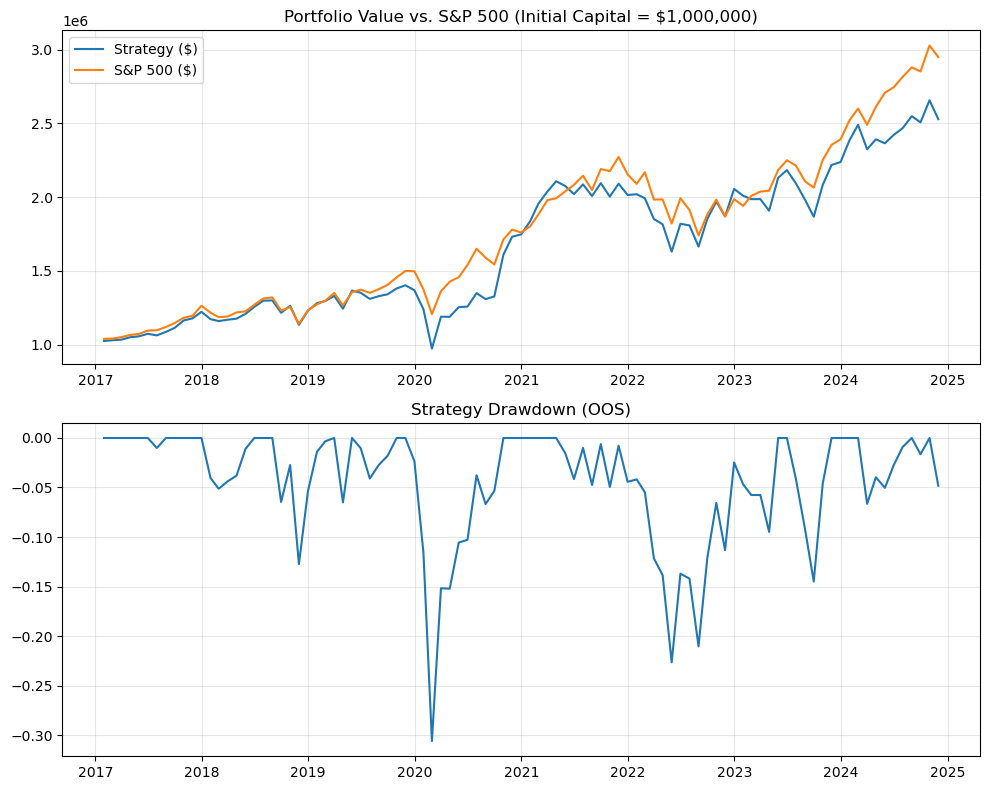

Period : 2017-01-31 → 2024-11-30 (n=95 months)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# CONFIG
# ===========================
BACKTEST_START = "2017-01-31"
BACKTEST_END   = "2024-12-31"
TOP_K          = 60
TC_BPS         = 5                   # round-trip cost (bps)
INIT_CAPITAL   = 1_000_000.0

# ===========================
# 0) Prep df_out and S&P series
# ===========================
panel = df_out.copy()
panel['date'] = pd.to_datetime(panel['date'])
panel['month_eom'] = panel['date'].dt.to_period('M').dt.to_timestamp('M')

# Score: use yhat_next (already t->t+1 prediction); if missing, route via regime
if 'yhat_next' not in panel.columns:
    if {'yhat_next_risk_on','yhat_next_risk_off','regime'}.issubset(panel.columns):
        panel['yhat_next'] = np.where(panel['regime'].astype(str).str.lower().eq('risk_on'),
                                      panel['yhat_next_risk_on'], panel['yhat_next_risk_off'])
    else:
        raise KeyError("Need 'yhat_next' or (yhat_next_risk_on, yhat_next_risk_off, regime).")

# Target: next-month stock excess return (required)
if 'excess_ret_next' not in panel.columns:
    raise KeyError("df_out must contain 'excess_ret_next' (next-month excess return).")

# S&P 500 next-month total return: use if present; otherwise build from df_factor.mkt_ret (shift -1)
if 'spx_ret_next' not in panel.columns:
    if 'df_factor' in globals() and 'mkt_ret' in df_factor.columns:
        mkt = df_factor[['date','mkt_ret']].drop_duplicates().copy()
        mkt['date'] = pd.to_datetime(mkt['date'])
        mkt['month_eom'] = mkt['date'].dt.to_period('M').dt.to_timestamp('M')
        spx = mkt.sort_values('month_eom').drop_duplicates('month_eom')
        spx['spx_ret_next'] = spx['mkt_ret'].shift(-1)
        panel = panel.merge(spx[['month_eom','spx_ret_next']], on='month_eom', how='left')
        print("[Built] spx_ret_next from df_factor.mkt_ret (shift -1 by month).")
    else:
        raise KeyError("Need S&P series: provide 'spx_ret_next' in df_out or df_factor with 'mkt_ret' to derive it.")

# Optional risk-free (only used for printing Sharpe; not required)
rf = None
if 'rf_1m' in panel.columns:
    rf = panel[['month_eom','rf_1m']].drop_duplicates('month_eom').set_index('month_eom')['rf_1m']

# Optional cap weights for a true CW benchmark (fallback is the S&P series itself)
if 'mktcap_lag1' in panel.columns:
    panel['mktcap_lag'] = panel['mktcap_lag1']
elif 'mktcap_lag' not in panel.columns:
    panel['mktcap_lag'] = np.nan  # placeholder

# Keep only what we need
panel = panel[['permno','month_eom','yhat_next','excess_ret_next','spx_ret_next','mktcap_lag']]

# Backtest months
months_all = panel['month_eom'].drop_duplicates().sort_values()
bt_months = months_all[(months_all >= pd.Timestamp(BACKTEST_START)) & (months_all <= pd.Timestamp(BACKTEST_END))]

# ===========================
# 1) Build benchmark series (S&P 500)
# ===========================
spx = panel[['month_eom','spx_ret_next']].drop_duplicates('month_eom').set_index('month_eom')['spx_ret_next']

# If you want a cap-weighted benchmark of the same universe (uses stock totals = spx + excess):
use_cw = panel['mktcap_lag'].notna().any()
if use_cw:
    tmp = panel.copy()
    tmp['ret_next_total'] = tmp['spx_ret_next'].astype(float) + tmp['excess_ret_next'].astype(float)
    def _cw(g):
        tot = g['mktcap_lag'].sum()
        if not np.isfinite(tot) or tot <= 0: return np.nan
        w = g['mktcap_lag'] / tot
        return float(np.nansum(w.values * g['ret_next_total'].values))
    bench = tmp.groupby('month_eom', sort=True).apply(_cw).rename('bench_ret').reindex(spx.index).fillna(spx)
else:
    bench = spx.copy()  # S&P 500 total return

# ===========================
# 2) Walk-forward strategy (TOP_K, proportional non-negative weights)
# ===========================
equity_curve = []
bench_curve  = []
prev_w = pd.Series(dtype=float)

for t in bt_months:
    g = panel.loc[panel['month_eom'] == t].copy()
    g = g.dropna(subset=['yhat_next','excess_ret_next','spx_ret_next'])
    if g.empty: 
        continue

    # rank & pick TOP_K
    pred = pd.Series(g['yhat_next'].values, index=g.index, name='pred').dropna()
    if pred.empty: 
        continue
    sel_ix = pred.sort_values(ascending=False).head(TOP_K).index

    # proportional non-negative weights; fallback equal-weight
    w = pd.Series(0.0, index=g.index)
    sel_scores = pred.loc[sel_ix].clip(lower=0)
    w.loc[sel_ix] = (sel_scores / sel_scores.sum()) if sel_scores.sum() > 0 else (1.0 / len(sel_ix))

    # turnover & cost
    prev_w = prev_w.reindex(w.index).fillna(0.0)
    turn = 0.5 * np.abs(w - prev_w).sum()
    cost = turn * (TC_BPS / 10000.0)
    prev_w = w.copy()

    # realized next-month total return = S&P next + weighted stock excess
    spx_t1 = float(spx.get(t, 0.0))
    y_ex   = g.loc[w.index, 'excess_ret_next'].astype(float)
    port_total = spx_t1 + float(np.nansum(w.values * y_ex.values)) - cost

    equity_curve.append((t, port_total))
    bench_curve.append((t, float(bench.get(t, np.nan))))

# ===========================
# 3) Portfolio values & plot
# ===========================
eq = pd.Series(dict(equity_curve)).sort_index()
bm = pd.Series(dict(bench_curve)).sort_index()
common = eq.index.intersection(bm.index)
eq, bm = eq.reindex(common), bm.reindex(common)

eq_cum = (1 + eq).cumprod()
bm_cum = (1 + bm).cumprod()

eq_dollar = INIT_CAPITAL * eq_cum
bm_dollar = INIT_CAPITAL * bm_cum

# ===========================
# METRICS SUMMARY (drop-in)
# ===========================
import numpy as np
import pandas as pd

def _perf_stats(total_ret, rf=None):
    rets = pd.Series(total_ret).dropna()
    if rets.empty: 
        return {}
    exc = rets if rf is None else (rets - pd.Series(rf).reindex(rets.index).fillna(0.0))
    n = len(rets)
    CAGR   = (1 + rets).prod()**(12/n) - 1.0
    vol    = exc.std(ddof=0) * np.sqrt(12)
    sharpe = np.nan if exc.std(ddof=0)==0 else exc.mean()/exc.std(ddof=0) * np.sqrt(12)
    downs  = exc[exc < 0]
    dvol   = downs.std(ddof=0) * np.sqrt(12)
    sortino= np.nan if dvol==0 else exc.mean()/downs.std(ddof=0) * np.sqrt(12)
    wealth = (1 + rets).cumprod()
    maxdd  = (wealth/wealth.cummax() - 1.0).min()
    calmar = np.nan if maxdd==0 else CAGR/abs(maxdd)
    hit    = (rets > 0).mean()
    return {'CAGR':CAGR, 'Vol':vol, 'Sharpe':sharpe, 'Sortino':sortino,
            'MaxDD':maxdd, 'Calmar':calmar, 'Hit':hit}

def _pct(x): 
    return ("{:+.2f}%".format(100*x)) if pd.notna(x) else "n/a"

# --- Try to reuse eq/bm from your backtest; else rebuild a minimal set ---
if 'eq' not in locals() or 'bm' not in locals():
    # Build from df_out if needed (assumes yhat_next & excess_ret_next present; spx_ret_next optional)
    _p = df_out.copy()
    _p['date'] = pd.to_datetime(_p['date'])
    _p['month_eom'] = _p['date'].dt.to_period('M').dt.to_timestamp('M')
    if 'spx_ret_next' not in _p.columns:
        raise RuntimeError("Need eq/bm or df_out['spx_ret_next'] to compute total-return metrics.")
    # naive equal-weight long top 30 by yhat_next just to form a quick curve (you already have a portfolio above)
    _eq = []
    for t, g in _p.groupby('month_eom'):
        if 'yhat_next' not in g.columns or 'excess_ret_next' not in g.columns: 
            continue
        pred = g['yhat_next'].dropna().sort_values(ascending=False).head(30)
        if pred.empty: 
            continue
        w = pred.clip(lower=0)
        w = w / w.sum() if w.sum() > 0 else pd.Series(1/len(pred), index=pred.index)
        ex = g.loc[w.index, 'excess_ret_next'].astype(float)
        sp = float(g['spx_ret_next'].iloc[0])
        _eq.append((t, sp + float((w*ex).sum())))
    eq = pd.Series(dict(_eq)).sort_index()
    bm = _p[['month_eom','spx_ret_next']].drop_duplicates('month_eom').set_index('month_eom')['spx_ret_next'].reindex(eq.index)

# --- RF series if available (optional) ---
rf_s = None
if 'rf_series' in locals() and isinstance(rf_series, (pd.Series, pd.DataFrame)):
    rf_s = rf_series if isinstance(rf_series, pd.Series) else rf_series.iloc[:,0]
    rf_s = rf_s.reindex(eq.index)

# --- Strategy & benchmark performance ---
perf       = _perf_stats(eq, rf=rf_s)
bench_perf = _perf_stats(bm, rf=rf_s)

# --- Relative metrics (alpha, beta, TE, IR) ---
common = eq.index.intersection(bm.index)
_eq = eq.reindex(common).astype(float)
_bm = bm.reindex(common).astype(float)

active = (_eq - _bm).dropna()
TE = active.std(ddof=0) * np.sqrt(12)
IR = np.nan if active.std(ddof=0)==0 else active.mean()/active.std(ddof=0) * np.sqrt(12)

X = np.vstack([np.ones(len(_bm)), _bm.values]).T
alpha_m, beta_ = np.linalg.lstsq(X, _eq.values, rcond=None)[0]
alpha_a = (1 + alpha_m)**12 - 1

# --- Avg monthly turnover if you tracked it ---
avg_turn = np.nan
if 'turn_series' in locals():
    try:
        ts = pd.Series(dict(turn_series))
        avg_turn = ts.mean()
    except Exception:
        pass

# --- IC diagnostics (if you saved pred_rows) ---
ic_mean = ic_std = ic_ir = np.nan
if 'pred_rows' in locals() and len(pred_rows):
    _pred_df = pd.concat(pred_rows, ignore_index=True)
    if {'month_eom','pred','y'}.issubset(_pred_df.columns):
        ics = (_pred_df.groupby('month_eom')
                        .apply(lambda g: g[['pred','y']].corr(method='spearman').iloc[0,1])
                        .dropna())
        if len(ics):
            ic_mean = float(ics.mean())
            ic_std  = float(ics.std(ddof=0))
            ic_ir   = (ic_mean/ic_std) if ic_std>0 else np.nan

# --- Pretty print to match your screenshot ---
print("OOS Backtest (monthly, no look-ahead; score lagged 1m, TOP_K & proportional weights)")
print(f"Period : {eq.index.min().date()} → {eq.index.max().date()} (n={len(eq)} months)")
print("Strategy |",
      "CAGR", _pct(perf.get('CAGR', np.nan)),
      "Vol", _pct(perf.get('Vol', np.nan)),
      "Sharpe", f"{perf.get('Sharpe', np.nan):.3f}" if pd.notna(perf.get('Sharpe', np.nan)) else "n/a",
      "Sortino", f"{perf.get('Sortino', np.nan):.3f}" if pd.notna(perf.get('Sortino', np.nan)) else "n/a",
      "MaxDD", _pct(perf.get('MaxDD', np.nan)),
      "Calmar", f"{perf.get('Calmar', np.nan):.3f}" if pd.notna(perf.get('Calmar', np.nan)) else "n/a",
      "Hit", f"{perf.get('Hit', np.nan):.3f}" if pd.notna(perf.get('Hit', np.nan)) else "n/a",
      "AvgTurn", f"{avg_turn:.3f}" if pd.notna(avg_turn) else "n/a")
print("Benchmark|",
      "CAGR", _pct(bench_perf.get('CAGR', np.nan)),
      "Vol", _pct(bench_perf.get('Vol', np.nan)),
      "Sharpe", f"{bench_perf.get('Sharpe', np.nan):.3f}" if pd.notna(bench_perf.get('Sharpe', np.nan)) else "n/a",
      "MaxDD", _pct(bench_perf.get('MaxDD', np.nan)))
print("Relative|",
      "Alpha_ann", _pct(alpha_a),
      "Beta", f"{beta_:.3f}",
      "TE", f"{TE:.3f}",
      "IR", f"{IR:.3f}")
print("IC diagnostics (OOS):",
      f"IC mean {ic_mean:.4f}, IC std {ic_std:.4f}, IC IR {ic_ir:.4f}")


plt.figure(figsize=(10,8))

ax1 = plt.subplot(2,1,1)
ax1.plot(eq_dollar.index, eq_dollar.values, label='Strategy ($)')
ax1.plot(bm_dollar.index, bm_dollar.values, label='S&P 500 ($)')
ax1.set_title(f"Portfolio Value vs. S&P 500 (Initial Capital = ${INIT_CAPITAL:,.0f})")
ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)

dd = eq_dollar/eq_dollar.cummax() - 1.0
ax2 = plt.subplot(2,1,2)
ax2.plot(dd.index, dd.values)
ax2.set_title("Strategy Drawdown (OOS)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# (Optional) quick print of period
if not eq.empty:
    print(f"Period : {eq.index.min().date()} → {eq.index.max().date()} (n={len(eq)} months)")
